In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from string import punctuation
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# データセットのダウンロード

In [ ]:
!mkdir data
!wget -P data http://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
!unzip "data/sentiment labelled sentences.zip"

mkdir: cannot create directory ‘data’: File exists
--2022-03-06 16:51:04--  http://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘data/sentiment labelled sentences.zip.1’

sentiment labelled  100%[===================>]  82.21K   292KB/s    in 0.3s    

2022-03-06 16:51:05 (292 KB/s) - ‘data/sentiment labelled sentences.zip.1’ saved [84188/84188]

Archive:  data/sentiment labelled sentences.zip
replace sentiment labelled sentences/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!mv "sentiment labelled sentences/"*.txt .
!cat amazon_cells_labelled.txt imdb_labelled.txt yelp_labelled.txt > data/sentiment_sentences.txt

# データ, モデルの読み込み

In [6]:
data_path = "data"
model_path = "/tmp/input/GoogleNews-vectors-negative300.bin.gz"
training_data_path = os.path.join(data_path,"sentiment_sentences.txt")
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('done loading Word2Vec')

# テキストデータとカテゴリの読み取り
texts = []
cats = []
fh = open(training_data_path)
for line in fh:
    text, sentiment = line.split("\t")
    texts.append(text)
    cats.append(sentiment)

done loading Word2Vec


In [3]:
# データセットの確認
print(len(cats), len(texts))
print(texts[1])
print(cats[1])

3000 3000
Good case, Excellent value.
1



# 前処理

In [4]:
# テキストの前処理
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        # 小文字化、ストップワードと数字の除去
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

texts_processed = preprocess_corpus(texts)
print(len(cats), len(texts_processed))
print(texts_processed[1])
print(cats[1])

3000 3000
['good', 'case', 'excellent', 'value']
1



In [7]:
# 文に含まれる単語の埋め込みを平均して、特徴ベクトルを作成
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens: # tokensに含まれる1単語ずつに対して
            if token in w2v_model: # モデルに単語が存在
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if count_for_this:
          feats.append(feat_for_this / count_for_this)
        else:
          feats.append(feat_for_this)
    return feats


train_vectors = embedding_feats(texts_processed)
print(len(train_vectors))

3000


# モデリング

In [8]:
logreg = LogisticRegression(random_state=1234)
train_data,test_data,train_cats,test_cats = train_test_split(train_vectors,cats)
logreg.fit(train_data,train_cats)
y_pred_cats = logreg.predict(test_data)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

Accuracy:  0.828


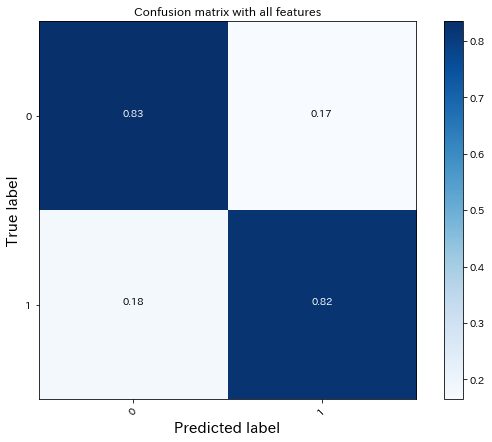

In [13]:
# 正解率
print("Accuracy: ", accuracy_score(test_cats, y_pred_cats))

    
# 混同行列
cnf_matrix = confusion_matrix(test_cats, y_pred_cats)
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,
    classes=['0', '1'],
    normalize=True,
    title='Confusion matrix with all features'
)